In [13]:
!rm -r /content/gcn/ /content/gcn-pytorch/

rm: cannot remove '/content/gcn/': No such file or directory


In [14]:
!git clone https://github.com/ArashMozhdehi/gcn_pytorch.git
# !cp -R /content/gcn-pytorch/gcn /content/gcn/

Cloning into 'gcn_pytorch'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [16]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install matplotlib==3.4
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-${TORCH}.html

In [17]:
import numpy as np
import pandas as pd
# from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
import torch
import torch.nn as nn

from gcn_pytorch.model import TwoLayerGCN, GCN, TwoLayerChebNet
from gcn_pytorch.trainer import Trainer, RunConfig
from gcn_pytorch.utils import Dataset, load_data, set_labels

In [4]:
def set_seed(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def compute_accuracy_per_hidden_layer_num(dataset: Dataset, residual: bool, opts, run_config, num_hidden, momentums):
    features, labels, train_labels, val_labels, test_labels, adjacency_matrix, \
    laplacian_matrix, num_classes = load_data(dataset)

    ignore_index = nn.CrossEntropyLoss().ignore_index
    overall_layers_train_accs, overall_layers_test_accs = [], []
    # for num_hidden_layers in range(2, num_hidden):
    overall_train_accs, overall_test_accs = [], []
    overall_epochs_train_accs, overall_epochs_test_accs = [], []
    for opt, momentum in zip(opts, momentums):
        cv = KFold(n_splits=5, shuffle=True, random_state=0)
        train_accs, test_accs = [], []
        train_epochs_accs, test_epochs_accs = [], []
        print(opt, momentum)
        for train_idx, test_idx in cv.split(np.array(list(range(labels.size(0))))):
            train_labels = set_labels(labels.clone(), train_idx, ignore_index)
            test_labels = set_labels(labels.clone(), test_idx, ignore_index)
            model = GCN(input_size=features.size(1), init="Xavier Normal", hidden_size=32, output_size=num_classes, dropout=0.5,
                        num_hidden_layers=num_hidden, residual=residual)

            trainer = Trainer(model, opt=opt, momentum=momentum)
            _, train_accuracy_dict, test_accuracy_dict =trainer.train(features, train_labels, val_labels, test_labels, adjacency_matrix, device, run_config, False)

            _, train_acc = trainer.evaluate(features, train_labels, adjacency_matrix, device)
            _, test_acc = trainer.evaluate(features, test_labels, adjacency_matrix, device)
            train_epochs_accs.append(list(train_accuracy_dict.values()))
            test_epochs_accs.append(list(test_accuracy_dict.values()))
            train_accs.append(train_acc)
            test_accs.append(test_acc)
        overall_epochs_train_accs.append(np.mean(np.array(train_epochs_accs), axis=0))
        overall_epochs_test_accs.append(np.mean(np.array(train_epochs_accs), axis=0))
        overall_train_accs.append(np.mean(train_accs))
        overall_test_accs.append(np.mean(test_accs))
    return overall_train_accs, overall_test_accs,  overall_epochs_train_accs, overall_epochs_test_accs 

In [ ]:
num_epochs = 2000
learning_rate = 0.01

In [ ]:
# def compute_residual_effect_df(dataset: Dataset):
run_config = RunConfig(learning_rate=learning_rate, num_epochs=num_epochs, weight_decay=5e-4, output_dir="tmp")
momentums = [0, 0, 0.05, 0.8, 0.9, 0.95, 0.995]
opts = ["RMSProp", "SGD", "SGD", "SGD", "SGD", "SGD", "Adam"]
set_seed()
epoch_train_acc_list, epoch_test_acc_list = [], []
train_acc, test_acc, epoch_train_acc, epoch_test_acc = compute_accuracy_per_hidden_layer_num(dataset=Dataset.Cora, residual=False, opts=opts, run_config=run_config, num_hidden=2, momentums=momentums)
epoch_train_acc_list.append(epoch_train_acc)
epoch_test_acc_list.append(epoch_test_acc)
train_acc, test_acc, epoch_train_acc, epoch_test_acc = compute_accuracy_per_hidden_layer_num(dataset=Dataset.CiteSeer, residual=False, opts=opts, run_config=run_config, num_hidden=2, momentums=momentums)
epoch_train_acc_list.append(epoch_train_acc)
epoch_test_acc_list.append(epoch_test_acc)
train_acc, test_acc, epoch_train_acc, epoch_test_acc = compute_accuracy_per_hidden_layer_num(dataset=Dataset.PubMed, residual=False, opts=opts, run_config=run_config, num_hidden=2, momentums=momentums)
epoch_train_acc_list.append(epoch_train_acc)
epoch_test_acc_list.append(epoch_test_acc)

Text(0.5, 1.0, 'PubMed')

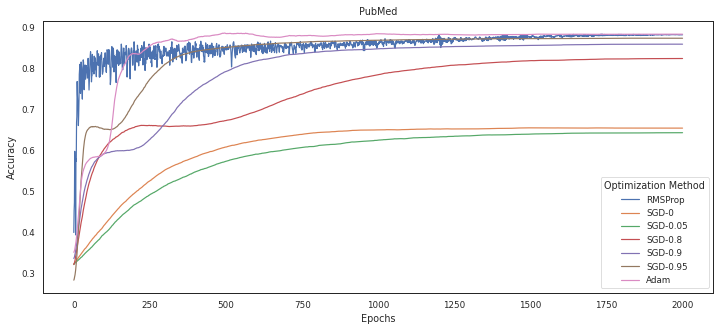

In [12]:
import copy
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('white')
sns.set_context("paper")
opt_mets = ["RMSProp", "SGD-0", "SGD-0.05", "SGD-0.8", "SGD-0.9", "SGD-0.95", "Adam"]
df = pd.DataFrame({
    "Epochs": [i for i in range(num_epochs)] * len(opt_mets),
    "Optimization Method": list(np.concatenate([[i] * num_epochs for i in opt_mets]).flat),
    "Accuracy": list(np.concatenate(epoch_train_acc[0]).flat),
})
sns.lineplot(data=df, x="Epochs", y="Accuracy", hue="Optimization Method")
plt.title("PubMed")

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('white')
sns.set_context("paper")
opt_mets = ["RMSProp", "SGD-0", "SGD-0.05", "SGD-0.8", "SGD-0.9", "SGD-0.95", "Adam"]
df = pd.DataFrame({
    "Epochs": [i for i in range(num_epochs)] * len(opt_mets),
    "Optimization Method": list(np.concatenate([[i] * num_epochs for i in opt_mets]).flat),
    "Accuracy": list(np.concatenate(epoch_train_acc[1]).flat),
})
sns.lineplot(data=df, x="Epochs", y="Accuracy", hue="Optimization Method")
plt.title("Cora")

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style('white')
sns.set_context("paper")
opt_mets = ["RMSProp", "SGD-0", "SGD-0.05", "SGD-0.8", "SGD-0.9", "SGD-0.95", "Adam"]
df = pd.DataFrame({
    "Epochs": [i for i in range(num_epochs)] * len(opt_mets),
    "Optimization Method": list(np.concatenate([[i] * num_epochs for i in opt_mets]).flat),
    "Accuracy": list(np.concatenate(epoch_train_acc[2]).flat),
})
sns.lineplot(data=df, x="Epochs", y="Accuracy", hue="Optimization Method")
plt.title("CiteSeer")